In [18]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlGDConfig,
    ControlEMVPConfig,
    ProposedMethodConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator
from cv_embedding_estimation import CrossValidationEmbeddingEstimator, estimate_embedding_cv


## Loading the dataset

In [2]:
# dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
dataset = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/lynx.csv',
                   index_col=0)
dataset.set_index('time', inplace=True)
dataset.head()

,value
time,
1821,269
1822,321
1823,585
1824,871
1825,1475


In [3]:
dataset.describe()

,value
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


In [4]:
# time_series = dataset['Value'].values
time_series = dataset['value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [5]:
# time_series_mu = np.mean(time_series)
# time_series_std = np.std(time_series)

# time_series = np.diff(time_series, prepend=time_series[0])
# time_series = (time_series - time_series_mu) / time_series_std
time_series = np.log10(time_series)

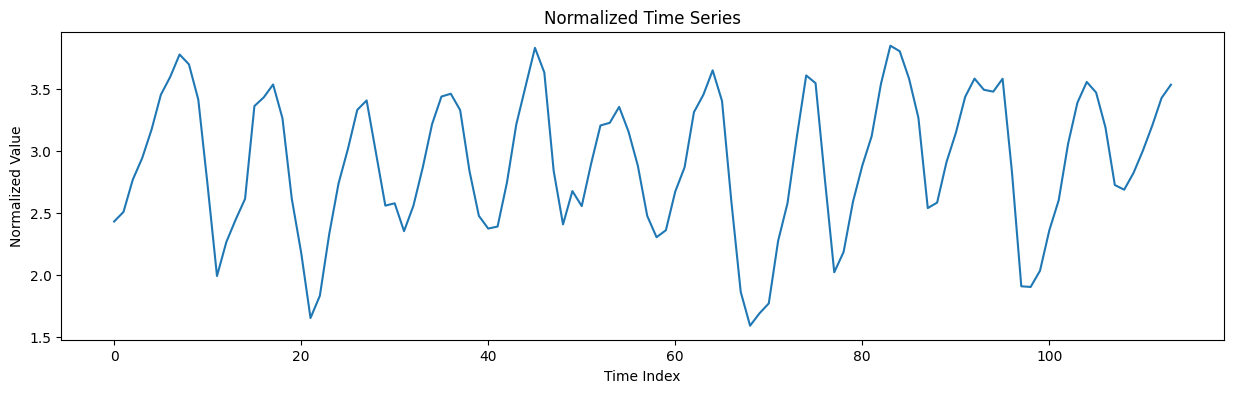

In [6]:
plt.figure(figsize=(15, 4))
plt.plot(time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [7]:
ami_tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {ami_tau}")

Estimated tau: 2


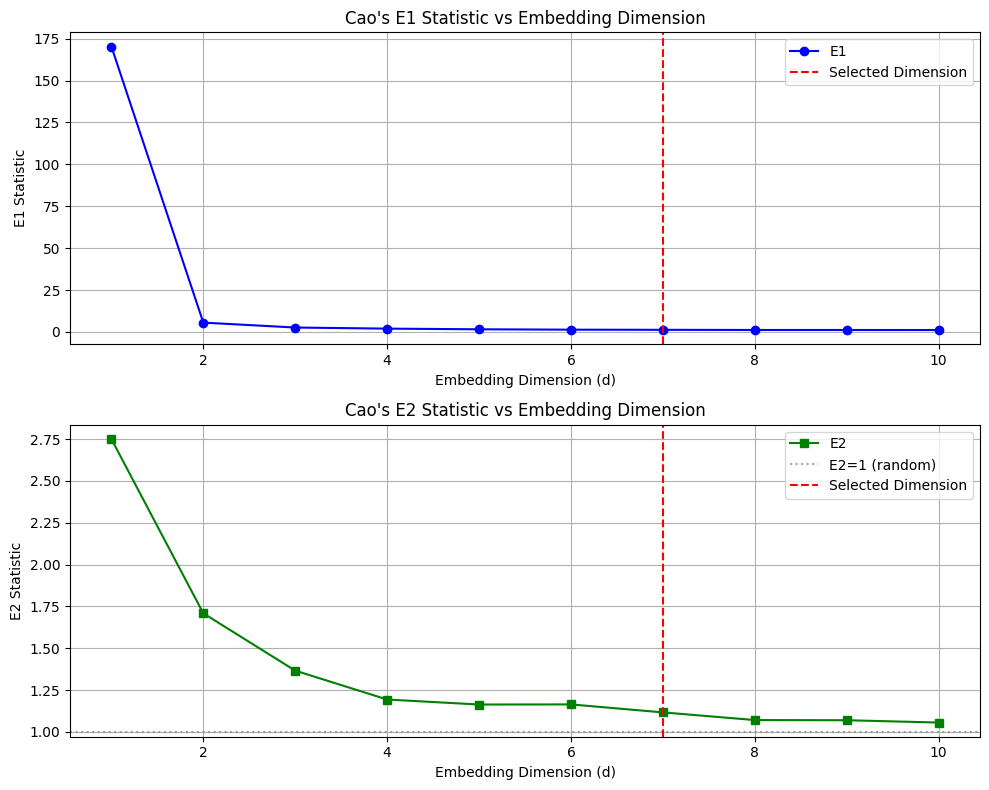

Estimated dimension: 7


In [ ]:
cao_dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=ami_tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=False,
    ),
)
print(f"Estimated dimension: {cao_dim}")

## Testing Cross-Validation Embedding Estimation

Let's compare the traditional AMI + Cao's method with the new modified multifold cross-validation criterion for embedding parameter estimation.

In [9]:
# Compare traditional AMI + Cao estimation with CV-based estimation
print("=== Traditional Methods (AMI + Cao) ===")
print(f"AMI estimated tau: {ami_tau}")
print(f"Cao estimated dimension: {cao_dim}")

# Use CV-based estimation with a smaller parameter space for faster computation
print("\n=== Cross-Validation Based Estimation ===")
cv_estimator = CrossValidationEmbeddingEstimator(
    tau_range=(1, 5),      # Smaller range for demonstration
    dim_range=(2, 6),      # Smaller range for demonstration  
    n_splits=3,            # Fewer splits for faster computation
    scoring_metric="mse",  # Mean squared error
    verbose=False
)

tau_cv, dim_cv = cv_estimator.estimate(time_series)
print(f"CV estimated tau: {tau_cv}")
print(f"CV estimated dimension: {dim_cv}")

=== Traditional Methods (AMI + Cao) ===
AMI estimated tau: 2
Cao estimated dimension: 7

=== Cross-Validation Based Estimation ===
CV estimated tau: 1
CV estimated dimension: 2


In [10]:
# You can also try different scoring metrics
print("\n=== CV with different scoring metrics ===")

metrics = ["mse", "mae", "r2"]
cv_results = {}

for metric in metrics:
    estimator = CrossValidationEmbeddingEstimator(
        tau_range=(1, 4),
        dim_range=(2, 5),
        n_splits=3,
        scoring_metric=metric,
        verbose=False  # Set to True to see progress
    )
    tau_est, dim_est = estimator.estimate(time_series)
    cv_results[metric] = (tau_est, dim_est)
    print(f"{metric.upper()} metric: tau={tau_est}, dim={dim_est}")

print(f"\nComparison:")
print(f"Traditional (AMI+Cao): tau={ami_tau}, dim={cao_dim}")
for metric, (tau_est, dim_est) in cv_results.items():
    print(f"CV ({metric}): tau={tau_est}, dim={dim_est}")


=== CV with different scoring metrics ===
MSE metric: tau=1, dim=2
MAE metric: tau=1, dim=2
R2 metric: tau=1, dim=2

Comparison:
Traditional (AMI+Cao): tau=2, dim=7
CV (mse): tau=1, dim=2
CV (mae): tau=1, dim=2
CV (r2): tau=1, dim=2


## Configuring the models

In [11]:
tau, dim = tau_cv, dim_cv

In [52]:
proposed_configs = [
    *[
        ProposedMethodConfig(
            approach=approach,
            optimizer=SvdOptimizer(epsilon=eps, alpha=alpha),
            # m=m,
            post_tune=post_tune,
            n=dim,
            embedding_tau=tau,
            tuning_val_split=0.3,
            ridge=ridge
        )
        # for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
        for alpha in [0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1, 5e-1, 1, 1.5, 2, 2.5, 3.5, 5, 8, 10, 20]
        for post_tune in [True, False]
        for eps in [0, 0.0001, 0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
        for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        for approach in ["pretraining", "no-pretraining"]
    ],
    # *[
    #     ProposedMethodConfig(
    #         approach=approach,
    #         optimizer=OlsOptimizer(rho=rho),
    #         m=max_m,
    #         n=dim,
    #         embedding_tau=tau,
    #         post_tune=post_tune,
    #     )
    #     for max_m in [50, 80]
    #     for rho in [0.01, 0.05, 0.1, 0.3, 0.6]
    #     for post_tune in [True, False]
    #     for approach in ["pretraining", "no-pretraining"]
    # ],
]

control_configs = [
    *[
        ControlGDConfig(
            m=m,
            n=dim,
            embedding_tau=tau,
            lr=lr,
            sigma_global=sigma_global,
            ridge=ridge,
            val_split=0.2,
        )
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
        for lr in [1e-3, 1e-2, 5e-2, 1e-1]
        for ridge in [0.0, 1e-4, 1e-3, 1e-2]
        for sigma_global in [False, True]
    ],
    *[
        ControlEMVPConfig(
            n=dim,
            embedding_tau=tau,
            num_components=m,
            ridge=ridge
        )
        for m in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
        for ridge in [0.0, 1e-4, 1e-3, 1e-2]
    ]
]

In [53]:
proposed_results, control_results = run_comparison_experiments(
        time_series,
        proposed_configs,
        control_configs,
        train_ratio=0.88, # 0.88 matches the article which introduces the EM-VP algorithm
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]
if not isinstance(control_results, list):
    control_results = [control_results]

Running Experiments: 100%|██████████| 3388/3388 [03:16<00:00, 17.25experiment/s] 


## Evaluating the results

In [67]:
results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test MSE": [],
        "Test RMSE": [],
        "Test NRMSE": [],
        "Test MAPE": [],
        "Test SMAPE": [],
        "Test MAAPE": [],
    }
)

for i, res in enumerate(proposed_results):
    
    cfg = proposed_configs[i]
    
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.metadata['optimizer_type']}-w.{cfg.approach}(m={res.metadata['total_centers']}, alpha={res.metadata['optimizer_params']['_alpha']}, eps={cfg.optimizer._epsilon} tuned={res.metadata['post_tuned']})" if res.metadata["optimizer_type"] == "SvdOptimizer" else
                f"{res.metadata['optimizer_type']}-w.{cfg.approach}(|C|={res.metadata['selected_centers']}, rho={res.metadata['optimizer_params']['_rho']} tuned={res.metadata['post_tuned']})"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test RMSE": [test_metrics.root_mean_squared_error()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [test_metrics.mean_squared_error()],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

for i, res in enumerate(control_results):
    
    cfg = control_configs[i]
    
    control_test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Control"],
            "Name": [f"{'GD' if isinstance(cfg, ControlGDConfig) else 'EM-VP'} (m={res.metadata.get('m_ctrl', cfg.num_components if isinstance(cfg, ControlEMVPConfig) else cfg.m)}, lr={cfg.lr if hasattr(cfg, 'lr') else np.nan}, ridge={cfg.ridge})"],
            "Test R": [control_test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [control_test_metrics.R2()],
            "Test RMSE": [control_test_metrics.root_mean_squared_error()],
            "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
            "Test MAPE": [control_test_metrics.mean_absolute_percentage_error()],
            "Test SMAPE": [control_test_metrics.symmetric_mean_absolute_percentage_error()],
            "Test MAAPE": [control_test_metrics.mean_arctangent_absolute_percentage_error()],
            "Test MSE": [control_test_metrics.mean_squared_error()],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

In [57]:
# PROPOSED_MODEL_SELECTION_CRITERION = "Test R^2"
# PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = True

PROPOSED_MODEL_SELECTION_CRITERION = "Test MSE"
PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = False

In [68]:
results_df.groupby("Type")[results_df.columns].apply(lambda x: x.sort_values(by=PROPOSED_MODEL_SELECTION_CRITERION, ascending=not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE).drop(columns=["Type"]).head(5))

Name    Test R  \
Type                                                                         
Control  3354                   EM-VP (m=4, lr=nan, ridge=0.001)  0.971482   
         3350                   EM-VP (m=3, lr=nan, ridge=0.001)  0.971894   
         3372                     EM-VP (m=9, lr=nan, ridge=0.0)  0.968479   
         3363                    EM-VP (m=6, lr=nan, ridge=0.01)  0.970334   
         3375                    EM-VP (m=9, lr=nan, ridge=0.01)  0.969463   
Proposed 886   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978072   
         894   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978072   
         902   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978071   
         896   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978065   
         890   SvdOptimizer-w.pretraining(m=100, alpha=0.01, ...  0.978064   

               Test R^2  Test MSE  Test RMSE  Test NRMSE  Test MAPE  \
Type                                                                  
Control  3354  0.937039  0.008633   0.092913    0.251877   0.025169   
         3350  0.936982  0.008641   0.092955    0.253155   0.024697   
         3372  0.936979  0.008641   0.092958    0.252376   0.027136   
         3363  0.936695  0.008680   0.093167    0.251569   0.026688   
         3375  0.936542  0.008701   0.093280    0.253974   0.026836   
Proposed 886   0.950985  0.006721   0.081980    0.216678   0.023502   
         894   0.950982  0.006721   0.081982    0.216684   0.023502   
         902   0.950978  0.006722   0.081985    0.216694   0.023504   
         896   0.950972  0.006722   0.081991    0.216726   0.023510   
         890   0.950970  0.006723   0.081992    0.216729   0.023510   

               Test SMAPE  Test MAAPE  
Type                                   
Control  3354    0.012756    0.025153  
         3350    0.012519    0.024681  
         3372    0.013639    0.027122  
         3363    0.013491    0.026674  
         3375    0.013544    0.026823  
Proposed 886     0.011733    0.023491  
         894     0.011734    0.023492  
         902     0.011734    0.023493  
         896     0.011737    0.023499  
         890     0.011738    0.023500

In [59]:
print(f"Best proposed model is: {results_df.sort_values(by=["Type", PROPOSED_MODEL_SELECTION_CRITERION], ascending=[False, not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(1)["Name"].values[0]}")

Best proposed model is: SvdOptimizer-w.pretraining(m=100, alpha=0.01, eps=0 tuned=True)


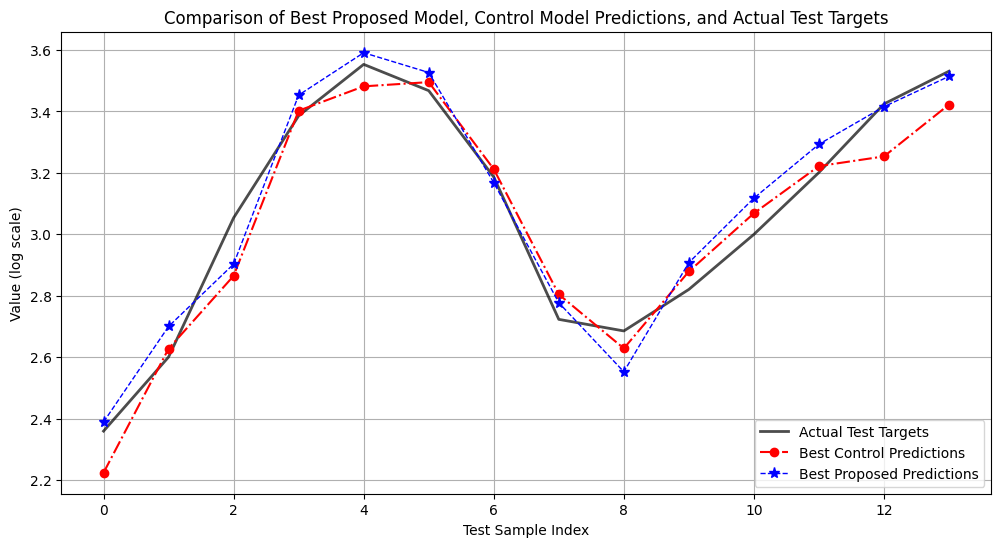

In [60]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_proposed_idx = results_df[results_df["Type"] == "Proposed"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmax() if PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Proposed"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmin()
best_proposed_res = proposed_results[best_proposed_idx]

best_control_idx = results_df[results_df["Type"] == "Control"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmax() if PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE else results_df[results_df["Type"] == "Control"][
    PROPOSED_MODEL_SELECTION_CRITERION
].idxmin()
best_control_res = control_results[best_control_idx - len(proposed_results)]

# Get test targets (actual values for test set)
test_targets = best_proposed_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label="Actual Test Targets", color="black", linewidth=2,  alpha=.7)
plt.plot(
    best_control_res.test_predictions,
    label=f"Best Control Predictions",
    color="red",
    linestyle="-.",
    marker='o',
)
plt.plot(
    best_proposed_res.test_predictions,
    label=f'Best Proposed Predictions',
    color="blue",
    linestyle="--",
    linewidth=1,
    marker='*',
    markersize=8,
)
plt.xlabel("Test Sample Index")
plt.ylabel("Value (log scale)")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()

### Control models

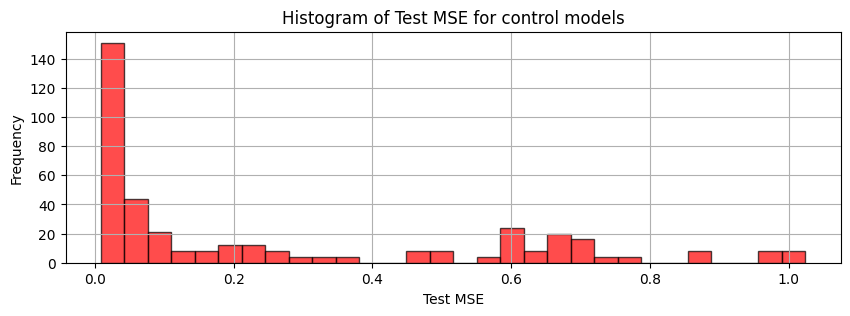

In [61]:
control_models = results_df[results_df["Type"] == "Control"]
plt.figure(figsize=(10, 3))
plt.hist(control_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for control models')
plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Breakdown of methods

#### Best OLS model without tuning

In [43]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
not_tuned_ols_models = results_df[
    results_df["Name"].str.contains("OLS", case=False, na=False)
    & results_df["Name"].str.contains("tuned=False", case=False, na=False)
]

if not_tuned_ols_models.empty:
    best_not_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_ols_model = not_tuned_ols_models.loc[
        (
            not_tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmin()
            if not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

if best_not_tuned_ols_model is None:
    print("No untuned OLS models found.")
else:
    print(best_not_tuned_ols_model["Name"])
    print("=" * 20)
    print(best_not_tuned_ols_model.drop(labels=["Type", "Name"]))

No untuned OLS models found.


In [44]:
if not not_tuned_ols_models.empty:
    plt.figure(figsize=(10, 3))
    plt.hist(not_tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for not tuned OLS Models')
    plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    print("No untuned OLS models found, skipping histogram.")

No untuned OLS models found, skipping histogram.


#### Best OLS-based model with tuning

In [46]:
# Filter for models with "OLS" in their name (case-insensitive) and "tuned=False"
tuned_ols_models = results_df[results_df["Name"].str.contains("OLS", case=False, na=False) & 
                        results_df["Name"].str.contains("tuned=True", case=False, na=False)]

if tuned_ols_models.empty:
    best_tuned_ols_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_ols_model = tuned_ols_models.loc[
        (
            tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmin()
            if not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

if best_tuned_ols_model is None:
    print("No tuned OLS models found.")
else:
    print(best_tuned_ols_model["Name"])
    print("="*20)
    print(best_tuned_ols_model.drop(labels=["Type", "Name"]))

No tuned OLS models found.


In [62]:
if tuned_ols_models.empty:
    print("No tuned OLS models found, skipping histogram.")
else:
    plt.figure(figsize=(10, 3))
    plt.hist(tuned_ols_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for tuned OLS models')
    plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

No tuned OLS models found, skipping histogram.


#### Best SVD-based model without tuning

In [63]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
not_tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
not_tuned_svd_models = not_tuned_svd_models[not_tuned_svd_models["Name"].str.contains("tuned=False", case=False, na=False)]

if not_tuned_svd_models.empty:
    best_not_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_not_tuned_svd_model = not_tuned_svd_models.loc[
        (
            not_tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmin()
            if not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else not_tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_not_tuned_svd_model["Name"])
print("="*20)
print(best_not_tuned_svd_model.drop(labels=["Type", "Name"]))

SvdOptimizer-w.no-pretraining(m=100, alpha=0.1, eps=0.0001 tuned=False)
Test R        0.978242
Test R^2      0.949323
Test MSE      0.006949
Test RMSE     0.083358
Test NRMSE    0.225657
Test MAPE     0.020401
Test SMAPE    0.010352
Test MAAPE    0.020387
Name: 1153, dtype: object


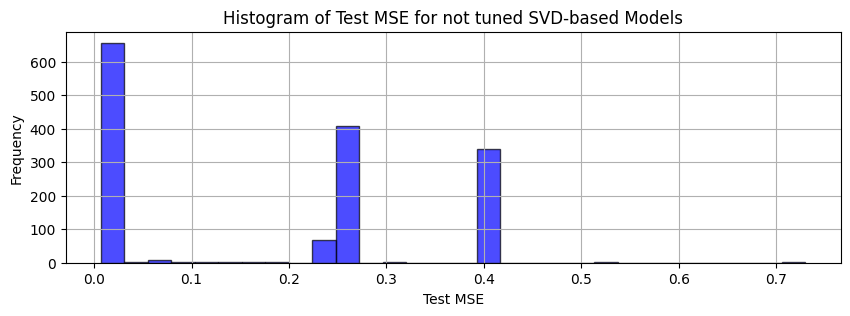

In [64]:
plt.figure(figsize=(10, 3))
plt.hist(not_tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for not tuned SVD-based Models')
plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Best SVD-based model with tuning

In [65]:
# Filter for models with "SVD" in their name (case-insensitive) and "tuned=True"
tuned_svd_models = results_df[results_df["Name"].str.contains("SVD", case=False, na=False)]
tuned_svd_models = tuned_svd_models[
    tuned_svd_models["Name"].str.contains("tuned=True", case=False, na=False)
]

if tuned_svd_models.empty:
    best_tuned_svd_model = None
else:
    # Select the best based on minimizing Test NRMSE
    best_tuned_svd_model = tuned_svd_models.loc[
        (
            tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmin()
            if not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE
            else tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION].idxmax()
        )
    ]

print(best_tuned_svd_model["Name"])
print("=" * 20)
print(best_tuned_svd_model.drop(labels=["Type", "Name"]))

SvdOptimizer-w.pretraining(m=100, alpha=0.01, eps=0 tuned=True)
Test R        0.978072
Test R^2      0.950985
Test MSE      0.006721
Test RMSE      0.08198
Test NRMSE    0.216678
Test MAPE     0.023502
Test SMAPE    0.011733
Test MAAPE    0.023491
Name: 886, dtype: object


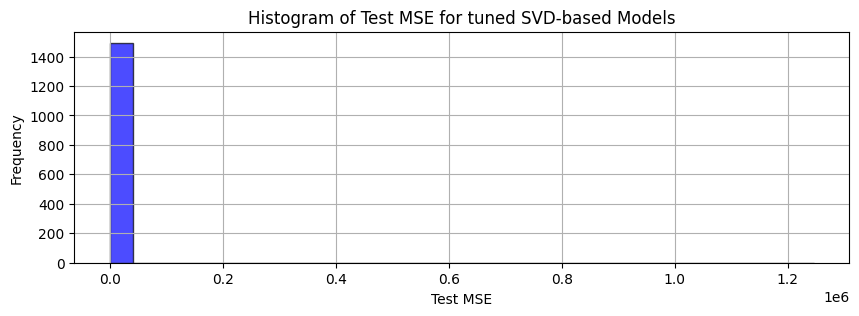

In [70]:
plt.figure(figsize=(10, 3))
plt.hist(tuned_svd_models[PROPOSED_MODEL_SELECTION_CRITERION], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Histogram of {PROPOSED_MODEL_SELECTION_CRITERION} for tuned SVD-based Models')
plt.xlabel(PROPOSED_MODEL_SELECTION_CRITERION)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()